<div class="alert alert-info" role="alert">
  <hr> <center> <font size="+3.5"> <b> Priorizing and Evaluating the Remedial Actions </b> </font> </center> <hr>
</div>

<a class="anchor" id="nutshell"></a>



<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setting-up-grid-simulation-environment-and-grid-snapshot" data-toc-modified-id="Setting-up-grid-simulation-environment-and-grid-snapshot-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setting up grid simulation environment and grid snapshot</a></span><ul class="toc-item"><li><span><a href="#Grid-simulation-environment" data-toc-modified-id="Grid-simulation-environment-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Grid simulation environment</a></span></li><li><span><a href="#Overload-Graph" data-toc-modified-id="Overload-Graph-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Overload Graph</a></span></li></ul></li><li><span><a href="#Create-AlphaDeesp" data-toc-modified-id="Create-AlphaDeesp-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Create AlphaDeesp</a></span></li><li><span><a href="#Detect-the-kind-of-problem" data-toc-modified-id="Detect-the-kind-of-problem-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Detect the kind of problem</a></span></li><li><span><a href="#Label-and-rank-the-substations" data-toc-modified-id="Label-and-rank-the-substations-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Label and rank the substations</a></span><ul class="toc-item"><li><span><a href="#Qualitative-ordering" data-toc-modified-id="Qualitative-ordering-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Qualitative ordering</a></span></li><li><span><a href="#Quantitative-Ranking" data-toc-modified-id="Quantitative-Ranking-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Quantitative Ranking</a></span></li></ul></li><li><span><a href="#Rank-the-topologies-among-substations" data-toc-modified-id="Rank-the-topologies-among-substations-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Rank the topologies among substations</a></span><ul class="toc-item"><li><span><a href="#substation-on-the-blue-upstream-path" data-toc-modified-id="substation-on-the-blue-upstream-path-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>substation on the blue upstream path</a></span></li><li><span><a href="#substation-on-red-path" data-toc-modified-id="substation-on-red-path-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>substation on red path</a></span></li><li><span><a href="#Overall-topologies-ranked" data-toc-modified-id="Overall-topologies-ranked-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Overall topologies ranked</a></span></li></ul></li><li><span><a href="#Simulate-and-Assess-the-remedial-Actions" data-toc-modified-id="Simulate-and-Assess-the-remedial-Actions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Simulate and Assess the remedial Actions</a></span></li><li><span><a href="#Plotting-action-effect" data-toc-modified-id="Plotting-action-effect-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Plotting action effect</a></span><ul class="toc-item"><li><span><a href="#Successful-trials" data-toc-modified-id="Successful-trials-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Successful trials</a></span></li><li><span><a href="#Unsuccessful-trials" data-toc-modified-id="Unsuccessful-trials-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Unsuccessful trials</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

In this notebook you will learn about how the Expert System prioritize remedial actions based on the Overload Distribution Graph that you have discoverd in notebook 1. And further how it assesses the success of its proposals.

In [1]:
import configparser
import numpy as np
import os
from alphaDeesp.core.grid2op.Grid2opObservationLoader import Grid2opObservationLoader
from alphaDeesp.core.grid2op.Grid2opSimulation import Grid2opSimulation

/home/marotant/dev/ExpertOp4Grid/venv_expert4grid/lib/python3.8/site-packages/grid2op/Backend/pandaPowerBackend.py:32: UserWarning: Numba cannot be loaded. You will gain possibly massive speed if installing it by 
	/home/marotant/dev/ExpertOp4Grid/venv_expert4grid/bin/python -m pip install numba

  warnings.warn(


In [2]:
plot_base_folder="output_plots"#where the plots will be saved

Here is the overall workflow for our Adaptive Expert System algorithm also described in the paper https://hal.science/hal-01897931/file/_LARGE__bf_Expert_System_for_topological_remedial_action_discovery_in_smart_grids.pdf

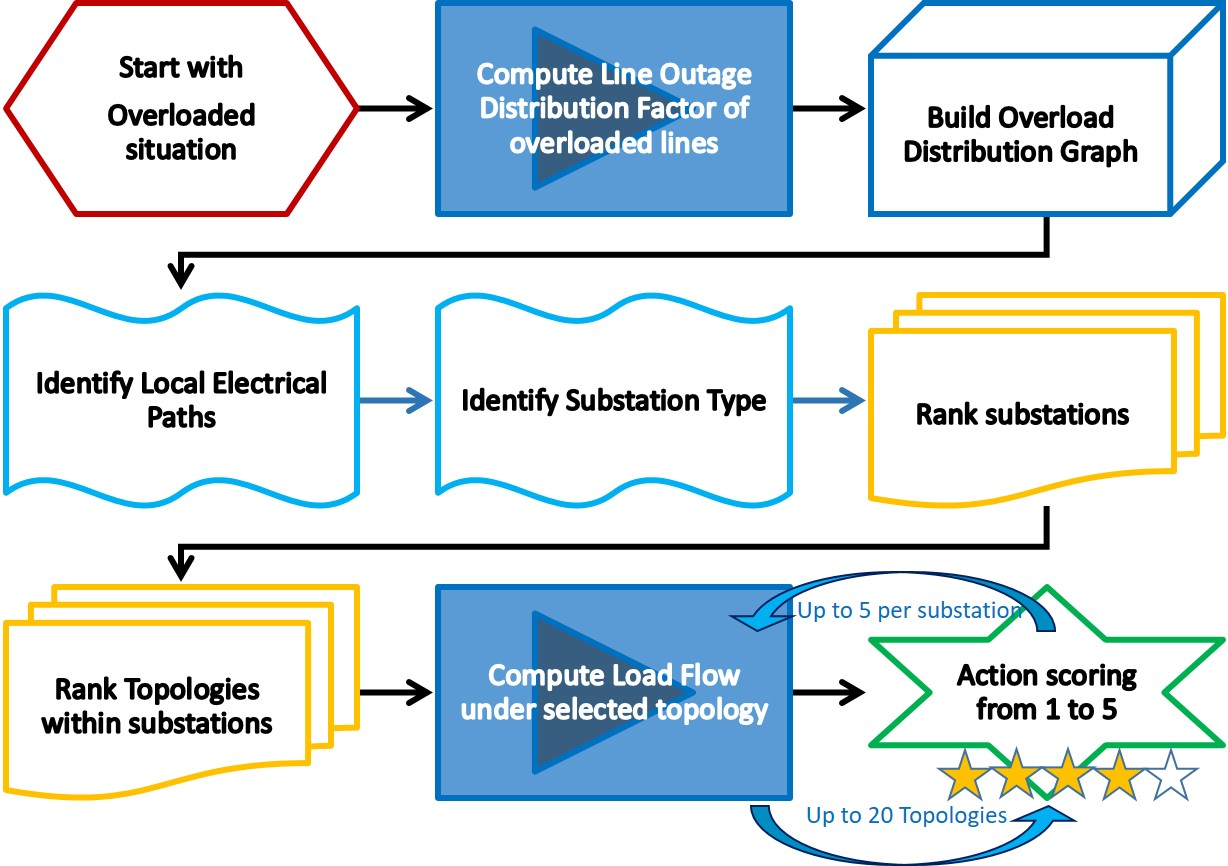

In [3]:
from IPython.display import Image

ExpertOpWorkflow_schematic_file_path="../alphaDeesp/ressources/SchemaSystemeExpert.jpg"
Image(filename=ExpertOpWorkflow_schematic_file_path) 


In this notebook, we will go through the last five steps:
- first ranking the possible topological remedial actions of interest
- then assessing how effective they actually are with a score of 1 to 5

# Setting up grid simulation environment and grid snapshot 

## Grid simulation environment

In [4]:
config = configparser.ConfigParser()
config.read("../alphaDeesp/ressources/config/config.ini")
param_folder = "../alphaDeesp/ressources/parameters/l2rpn_2019/"

chronicscenario=0
timestep=0

loader = Grid2opObservationLoader(param_folder)
env, obs, action_space = loader.get_observation(chronic_scenario= chronicscenario, timestep=timestep)
observation_space = env.observation_space




You might need to install the LightSimBackend (provisory name) to gain massive speed up
INFO - An integer has been provided as chronic scenario - looking for the chronic folder in this position
INFO - the name of the loaded Grid2op scenario is : a


## Overload Graph

Loading it as it was in previous notebook

In [5]:
from alphaDeesp.main import generate_plot_folders
from alphaDeesp.core.graphsAndPaths import OverFlowGraph


ltc=[9]#overloaded line to solve
plot_folder = generate_plot_folders(plot_base_folder, [ltc],chronicscenario,timestep, config)

sim = Grid2opSimulation(obs, action_space, observation_space, param_options=config["DEFAULT"], debug=False,
                                 ltc=ltc,plot=True, plot_folder = plot_folder)

g_over =  OverFlowGraph(sim.topo, ltc, sim.get_dataframe())#sim.build_graph_from_data_frame(ltc)


self.default output path =  output_plots/l2rpn_2019/linetocut_[9]/Scenario_0/Timestep_0
Number of generators of the powergrid: 5
Number of loads of the powergrid: 11
Number of powerline of the powergrid: 20
Number of elements connected to each substations in the powergrid: [3 6 4 6 5 6 3 2 5 3 3 3 4 3]
Total number of elements: 56
    idx_or  idx_ex  init_flows  swapped  new_flows  new_flows_swapped  \
0        0       1     157.837    False    161.994              False   
1        0       4      75.622    False     74.356              False   
2        1       2      76.303    False     78.780              False   
3        1       3      55.295    False     60.271              False   
4        1       4      40.187    False     36.657              False   
5        3       2      20.677     True     18.370              False   
6        4       3      63.253     True     98.744              False   
7        3       6      30.408    False     57.576              False   
8        3

self.default output path =  


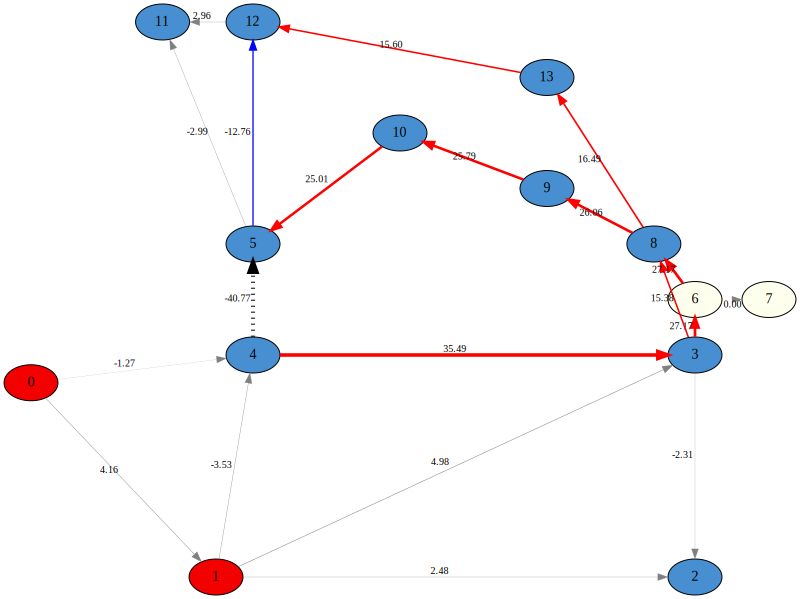

In [6]:
rescale_factor=70#for better layout, you can play with it to change the zoom level
layout_rescale=[(e[0]/rescale_factor,e[1]/rescale_factor) for e in sim.layout]
svg=g_over.plot(layout_rescale,save_folder="")

from IPython.display import SVG, display
SVG(svg)

With a more hierarchical flow representation

self.default output path =  


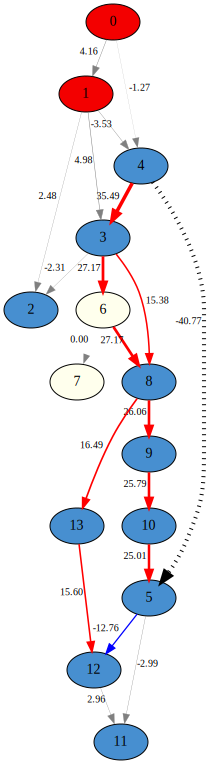

In [7]:
svg=g_over.plot(None,save_folder="")
from IPython.display import SVG, display
SVG(svg)

# Create AlphaDeesp 

This is the class similar to an agent where the intelligence lies to interpret this graph and make proposals.

In [8]:
from alphaDeesp.core.alphadeesp import AlphaDeesp
simulator_data = {"substations_elements": sim.get_substation_elements(),
                      "substation_to_node_mapping": sim.get_substation_to_node_mapping(),
                      "internal_to_external_mapping": sim.get_internal_to_external_mapping()}

alphadeesp = AlphaDeesp(g_over.get_graph(), sim.get_dataframe(), simulator_data,sim.substation_in_cooldown)

Constrained path created
In get_hubs(): c = 
################################################################
ConstrainedPath = [4, 5, 12] 
Details: (amont: [], constrained_edge: (4, 5, 0), aval: [(5, 12, 0)])
################################################################


# Detect the kind of problem

A flow problem can be ranked in 3 categories:
    - 1) production bottleneck, i.e. not enough line capacity to dispatch the neighboring production
    - 2) power transport issue in the meshed grid
    - 3 consumption bottleneck, not enough line capacity to supply neighboring consumptions.

A production bottleneck or consumption bottleneck will be represented by an overload distribution graph with only a blue path, with productions (red node) upstream in 1) or loads (blue node) downstream in 3)

There are no topological remedial action in this case, you can only decrease the upstream production in 1) and redispatch this production elsewhere, or decrease the downstream loads in 3).

The expert system can hence detect those two cases, but leave it to the human operator to decide the amount of decrease to apply.

Next we will see how the **expert system helps manage more complex cases 2) of power transport.**

In [9]:
#check if is antenna, so bottleneck of either production or consumption
isAntenna_Sub=sim.isAntenna()
if isAntenna_Sub:
    print("the problem is identified as either a botleneck of production or consumption, aka antenna. We will leave it to the human operator to figure out how to adjust the local production or load")
else:
    print("the problem is of type power transport and we will see step by step how alphadeesp helps manage this")

the problem is of type power transport and we will see step by step how alphadeesp helps manage this


# Label and rank the substations

## Qualitative ordering

Considering the Overload distribution graphs highlight both blue and red paths, substations can be tagged with different roles:
    - 1) hubs (nodes 4, 5, 12) where both blue and red paths meet, where more flexibility should exist 
    - 2) other nodes on constrained path (none here) where to slow down flows using node splitting for instance and distributing upstream and downstream blue path on different nodes
    - 3) nodes on red parallel or loop paths (nodes 3,6,8,9,10,13) where to push the flows by merging nodes for instance.

Substations are first qualitatively ranked in this order of categories. 

In [10]:
#1) Hubs, 2) nodes on constrained path upstream and in between loop paths, 
#3) nodes on parallel path, 4) downstream constrained path beyond red loops
alphadeesp.identify_routing_buses()

{1: [4, 5, 12], 2: set(), 3: [3, 6, 8, 9, 10, 13], 4: set()}

## Quantitative Ranking 

The quantitative ranking of nodes should be based on max of total coloured inflow vs outflow at each node. This should be added: TODO

For now it just goes in appearing order per category as seen above

# Rank the topologies among substations

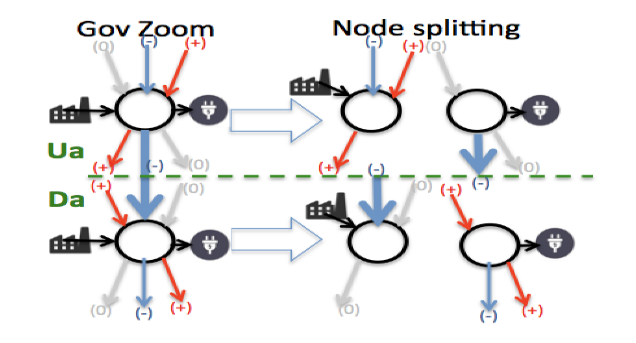

In [11]:
Hubs_explained_file_path="Hubs_redirecting_flows.png"
Image(filename=Hubs_explained_file_path)

## substation on the blue upstream path

Either a hub or not, you find the node that is not connex to the overload and then you compute your score:

- score = sum(in_blue_flows) + max(sum(in_red_flows),sum(out_red_flows)) + diff(production - load) #if upstream
- score = sum(out_blue_flows) + max(sum(in_red_flows),sum(out_red_flows)) + diff(load - production) #if downstream

Grey edges are not totally taken into account here and that could be improved for smoother reconfiguration


In [12]:
#rank_current_topo_at_node_x(
sub=4#this is a hub
all_combinations = alphadeesp.compute_all_combinations(sub)
print("all 2 node splitting configurations at node "+str(sub))
print(all_combinations)


all 2 node splitting configurations at node 4
[[0, 0, 0, 1, 1], [0, 0, 1, 0, 1], [0, 0, 1, 1, 0], [0, 0, 1, 1, 1], [0, 1, 0, 0, 1], [0, 1, 0, 1, 0], [0, 1, 0, 1, 1], [0, 1, 1, 0, 0], [0, 1, 1, 0, 1], [0, 1, 1, 1, 0]]


In [13]:
topo_ranking_score_df=alphadeesp.rank_topologies(all_combinations, g_over, sub)
topo_ranking_score_df

,score,topology,node
0,XX,"[X, X, X]",X
1,39.020,"[0, 0, 0, 1, 1]",4
2,36.760,"[0, 0, 1, 0, 1]",4
3,4.800,"[0, 0, 1, 1, 0]",4
4,40.290,"[0, 0, 1, 1, 1]",4
5,-2.800,"[0, 1, 0, 0, 1]",4
6,29.160,"[0, 1, 0, 1, 0]",4
7,-6.330,"[0, 1, 0, 1, 1]",4
8,31.420,"[0, 1, 1, 0, 0]",4
9,-4.070,"[0, 1, 1, 0, 1]",4


The topology (0,0,0,1,1) at sub 4 correspond to lines (0->4, 1->4, 4->3) on node 1 and (line 4->5, load_sub4) on node 2.  

sum(in_blue_flows) = 0

max(sum(in_red_flows),sum(out_red_flows)) = max( 0, 35.5)=35.5

diff(production - load)=(0-0) - (0-3.5)=3.5 (as on the initial node there was 3.5MW of load and on resulting node 1 there is none anymore)

score=39

Then you select the top k actions with the best score a priori

## substation on red path

Find substations where nodes are already split to merge them and decrease the impedence

Then take the substations with nodes that have the largest total red ingoing flow

score = sum(in_red_flows)

## Overall topologies ranked

here we find all possible two nodes topologies per selected substations
We compute their score a priori for rerouting the overflow

In [14]:
ranked_combinations = alphadeesp.get_ranked_combinations()
ranked_combinations

[              topology node
 score                      
 40.29  [0, 0, 1, 1, 1]    4
 39.02  [0, 0, 0, 1, 1]    4
 36.76  [0, 0, 1, 0, 1]    4
 31.42  [0, 1, 1, 0, 0]    4
 29.16  [0, 1, 0, 1, 0]    4
 27.89  [0, 1, 1, 1, 0]    4
 4.8    [0, 0, 1, 1, 0]    4
 -2.8   [0, 1, 0, 0, 1]    4
 -4.07  [0, 1, 1, 0, 1]    4
 -6.33  [0, 1, 0, 1, 1]    4,
                  topology node
 score                         
 51.96  [0, 1, 1, 1, 1, 0]    5
 48.97  [0, 1, 1, 0, 1, 0]    5
 48.97  [0, 0, 0, 1, 0, 1]    5
 40.76  [0, 0, 1, 1, 1, 0]    5
 40.76  [0, 1, 0, 0, 0, 1]    5
 39.2   [0, 0, 1, 0, 0, 1]    5
 39.2   [0, 1, 0, 1, 1, 0]    5
 37.77  [0, 1, 0, 1, 0, 1]    5
 37.77  [0, 0, 1, 0, 1, 0]    5
 36.21  [0, 0, 1, 1, 0, 1]    5
 36.21  [0, 1, 0, 0, 1, 0]    5
 28.0   [0, 0, 0, 1, 1, 0]    5
 28.0   [0, 1, 1, 0, 0, 1]    5
 26.95  [0, 1, 1, 1, 0, 0]    5
 26.95  [0, 0, 0, 0, 1, 1]    5
 25.01  [0, 1, 1, 1, 0, 1]    5
 23.96  [0, 1, 1, 0, 0, 0]    5
 23.96  [0, 0, 0, 1, 1, 1]    5
 15.75  [0,

# Simulate and Assess the remedial Actions

Let's now look at the results of the selected actions, finding out if they are good remedial actions or not

We give the actions a simulated score combined with an efficacy to reroute the flow of the overload:
    
- 4 - it solves all overloads,
- 3 - it solves only the overload of interest
- 2 - it partially solves the overload of interest
- 1 - it solves the overload of interest but worsen other overloads
- 0 - it fails to relieve even partially the overload


In [15]:
expert_system_results, actions = sim.compute_new_network_changes(ranked_combinations)


##############################################################################
##########...........COMPUTE NEW NETWORK CHANGES..........####################
##############################################################################
########### Compute new network changes on node [4] with new topo [[1 1 2 2 2]] ###########
########### Compute new network changes on node [4] with new topo [[1 1 1 2 2]] ###########
########### Compute new network changes on node [4] with new topo [[1 1 2 1 2]] ###########
########### Compute new network changes on node [4] with new topo [[1 2 2 1 1]] ###########
########### Compute new network changes on node [4] with new topo [[1 2 1 2 1]] ###########
########### Compute new network changes on node [4] with new topo [[1 2 2 2 1]] ###########
########### Compute new network changes on node [4] with new topo [[1 1 2 2 1]] ###########
########### Compute new network changes on node [4] with new topo [[1 2 1 1 2]] ###########
########### Compute new ne

In [16]:
expert_system_results

,overflow ID,Flows before,Flows after,Delta flows,Worsened line,Prod redispatched,Load redispatched,Internal Topology applied,Topology applied,Substation ID,Rank Substation ID,Topology score,Topology simulated score,Efficacity
0,9,40.768,-7.600,48.368,[6],4.172,0.000,"[0, 0, 1, 1, 1]","[2, 2, 2, 1, 1]",4,1,40.290,1,249.537
1,9,40.768,48.570,-7.801,[9],0.832,0.000,"[0, 0, 0, 1, 1]","[1, 2, 2, 1, 1]",4,1,39.020,0,-6.461
2,9,40.768,38.618,2.151,[],0.012,0.000,"[0, 0, 1, 0, 1]","[2, 1, 2, 1, 1]",4,1,36.760,4,2.240
3,9,40.768,51.024,-10.256,[9],1.266,0.000,"[0, 1, 1, 0, 0]","[2, 1, 1, 2, 1]",4,1,31.420,0,-8.087
4,9,40.768,40.549,0.220,[],0.128,0.000,"[0, 1, 0, 1, 0]","[1, 2, 1, 2, 1]",4,1,29.160,2,0.218
5,9,40.768,58.262,-17.494,"[2, 3, 9]",3.677,0.000,"[0, 1, 1, 1, 0]","[2, 2, 1, 2, 1]",4,1,27.890,0,-12.063
6,9,40.768,35.204,5.564,"[2, 3]",12.354,0.000,"[0, 0, 1, 1, 0]","[2, 2, 1, 1, 1]",4,1,4.800,1,6.346
7,9,40.768,35.531,5.237,"[2, 3]",10.699,0.000,"[0, 1, 0, 0, 1]","[1, 1, 2, 2, 1]",4,1,-2.800,1,5.929
8,9,40.768,39.739,1.029,[],0.482,0.000,"[0, 1, 1, 0, 1]","[2, 1, 2, 2, 1]",4,1,-4.070,4,1.032
9,9,40.768,39.100,1.669,[2],6.289,0.000,"[0, 1, 0, 1, 1]","[1, 2, 2, 2, 1]",4,1,-6.330,1,1.710


<AxesSubplot:>

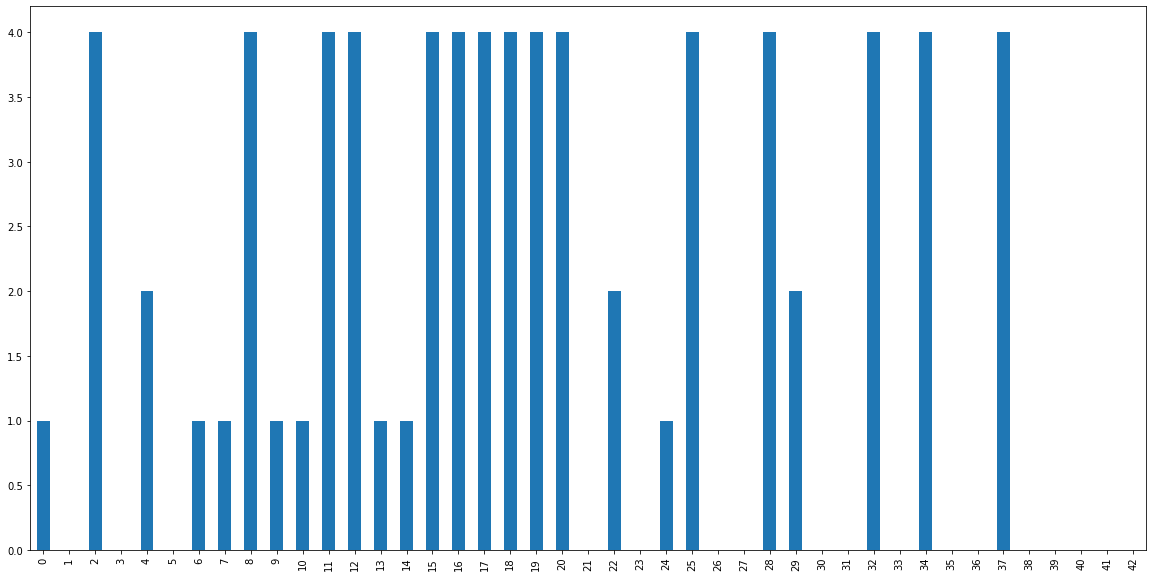

In [17]:
expert_system_results["Topology simulated score"].plot.bar(x='ranking',y='simulated score',figsize=(20,10))

First topology [0, 0, 1, 1, 1] at substation 4 is effective for the overload but worsen another line, so it get a score of 1

Third topology [0, 0, 1, 0, 1] at substation 4 relieve the overload completely and don't create new ones, it gets a score of 4

Fourth topology [0, 1, 0, 1, 0] relieves the overload lightly so get a score of 2.

A score of 3 would be reach if a given overload is relieved without worsening, but some overloads still need to be resolved elsewhere


Substation ID
5     7
3     3
4     2
8     2
12    1
Name: count, dtype: int64


<AxesSubplot:>

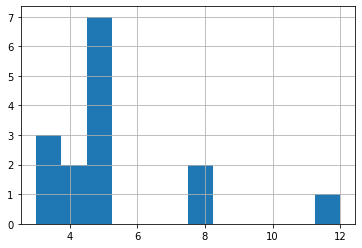

In [18]:
print(expert_system_results[expert_system_results["Topology simulated score"]==4]["Substation ID"].value_counts())
expert_system_results[expert_system_results["Topology simulated score"]==4]["Substation ID"].hist(bins=12)


We see that subsation 5 as a hub with many elements seems to be the most effective location with the most successful trials
In terms of efficacy, that is the amount of flow redispatched, it is also a very intesresting location. However if too much flow is redispatched, it necessarily overloads other lines, which explains scores of 1 obtained.

# Plotting action effect

Reminding the initial overloaded state

/tmp/ipykernel_1347779/3332567725.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


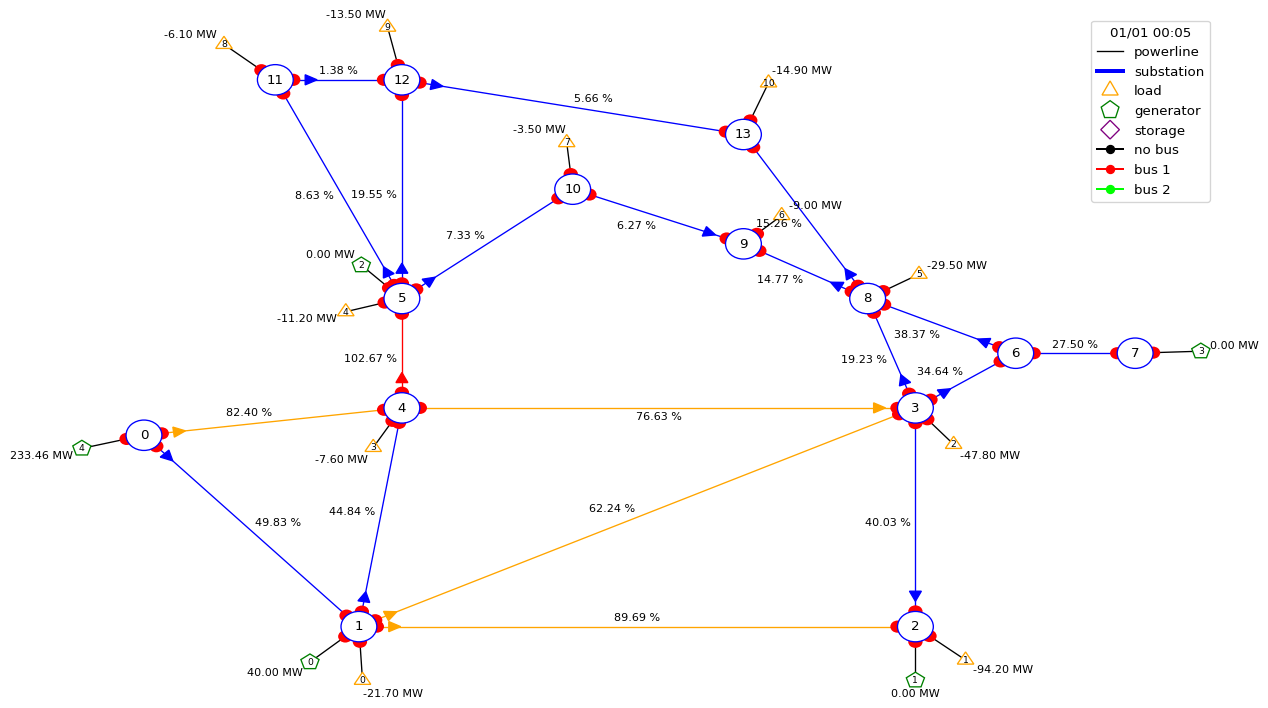

In [19]:
from grid2op.PlotGrid import PlotMatplot

obs=env.get_obs()

plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_obs(obs)
fig.show()

## Successful trials

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - NOT force any line status
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - Set the bus of the following element(s):
	 	 - Assign bus 2 to line (extremity) id 1 [on substation 4]
	 	 - Assign bus 1 to line (extremity) id 4 [on substation 4]
	 	 - Assign bus 2 to line (extremity) id 6 [on substation 4]
	 	 - Assign bus 1 to line (origin) id 9 [on substation 4]
	 	 - Assign bus 1 to load id 3 [on substation 4]


/tmp/ipykernel_1347779/2791909177.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


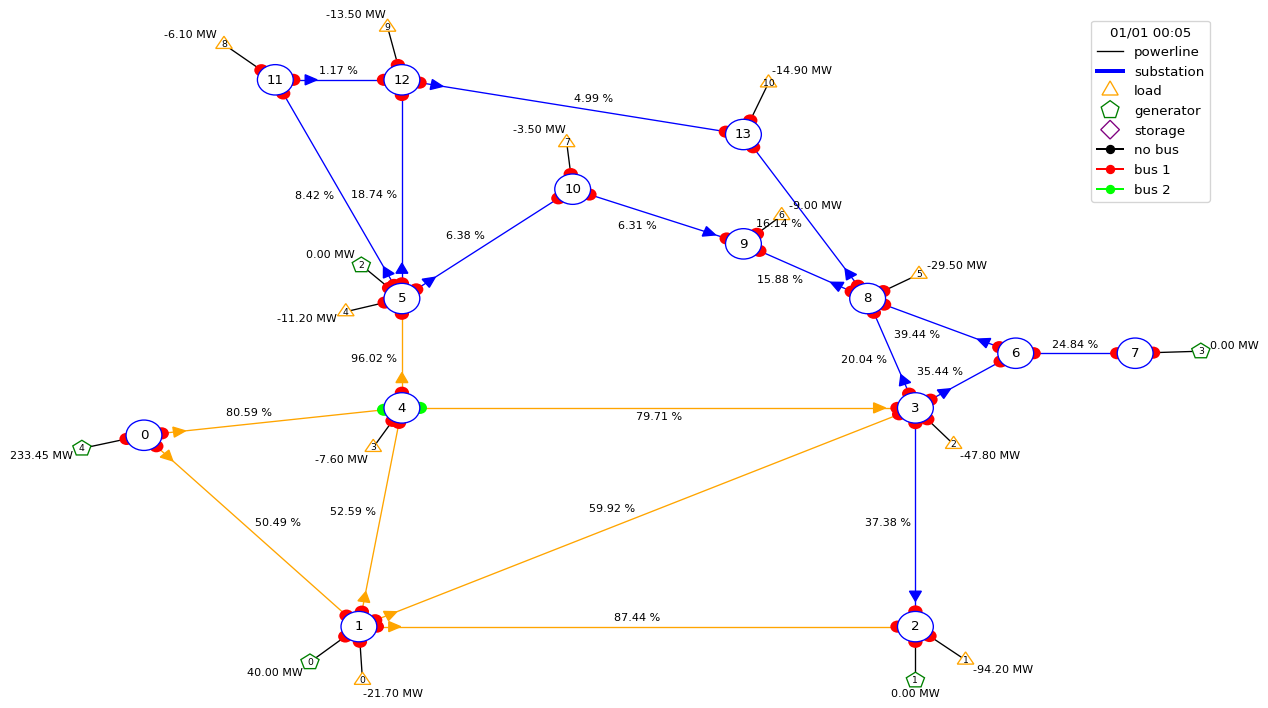

In [20]:
id_act=2
act=actions[id_act]
print(act)

obs_sim,*_=obs.simulate(act,time_step=0)

# if you want to plot all the observation
fig = plot_helper.plot_obs(obs_sim)
fig.show()

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - NOT force any line status
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - Set the bus of the following element(s):
	 	 - Assign bus 1 to line (extremity) id 9 [on substation 5]
	 	 - Assign bus 2 to line (origin) id 10 [on substation 5]
	 	 - Assign bus 1 to line (origin) id 11 [on substation 5]
	 	 - Assign bus 2 to line (origin) id 12 [on substation 5]
	 	 - Assign bus 1 to generator id 2 [on substation 5]
	 	 - Assign bus 2 to load id 4 [on substation 5]


/tmp/ipykernel_1347779/3249247057.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


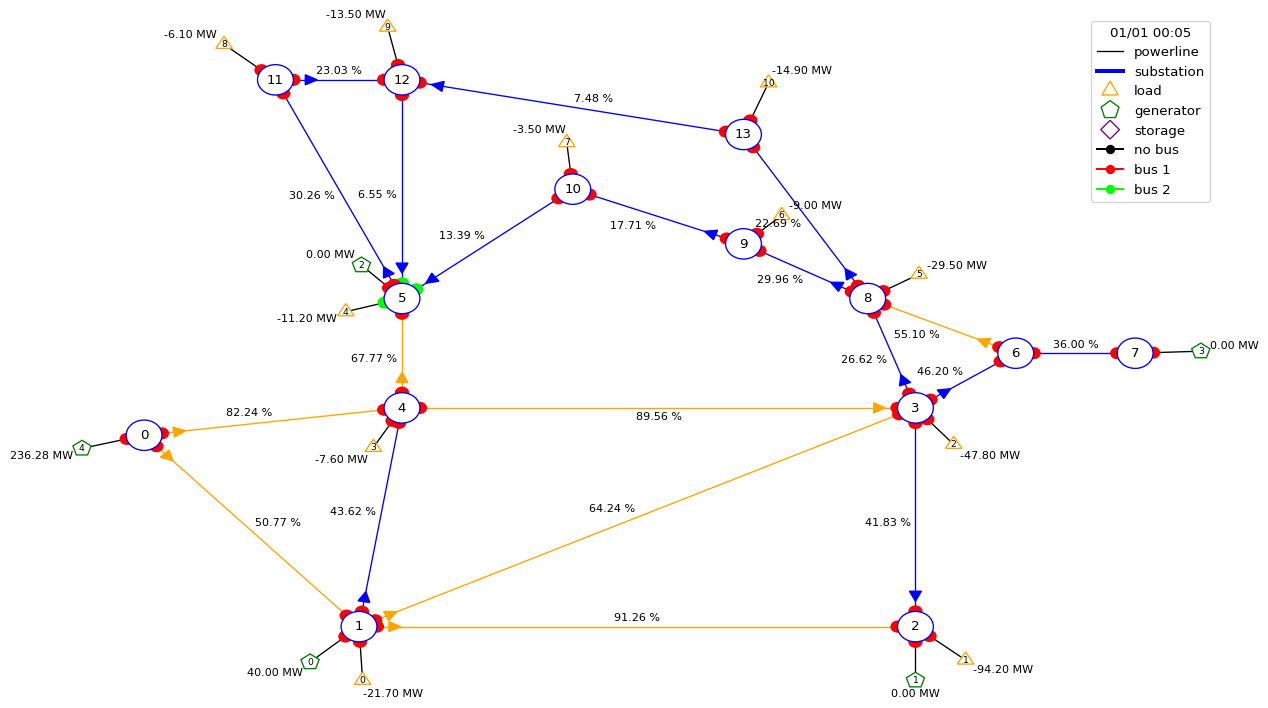

In [21]:
id_act=11
act=actions[id_act]
print(act)

obs_sim,*_=obs.simulate(act,time_step=0)

# if you want to plot all the observation
fig = plot_helper.plot_obs(obs_sim)
fig.show()

We see that line 9 (from substations 4->5) is overloaded

## Unsuccessful trials 

Too much flow redispatched that worsen other lines

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - NOT force any line status
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - Set the bus of the following element(s):
	 	 - Assign bus 2 to line (extremity) id 1 [on substation 4]
	 	 - Assign bus 2 to line (extremity) id 4 [on substation 4]
	 	 - Assign bus 2 to line (extremity) id 6 [on substation 4]
	 	 - Assign bus 1 to line (origin) id 9 [on substation 4]
	 	 - Assign bus 1 to load id 3 [on substation 4]


/tmp/ipykernel_1347779/2138353423.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


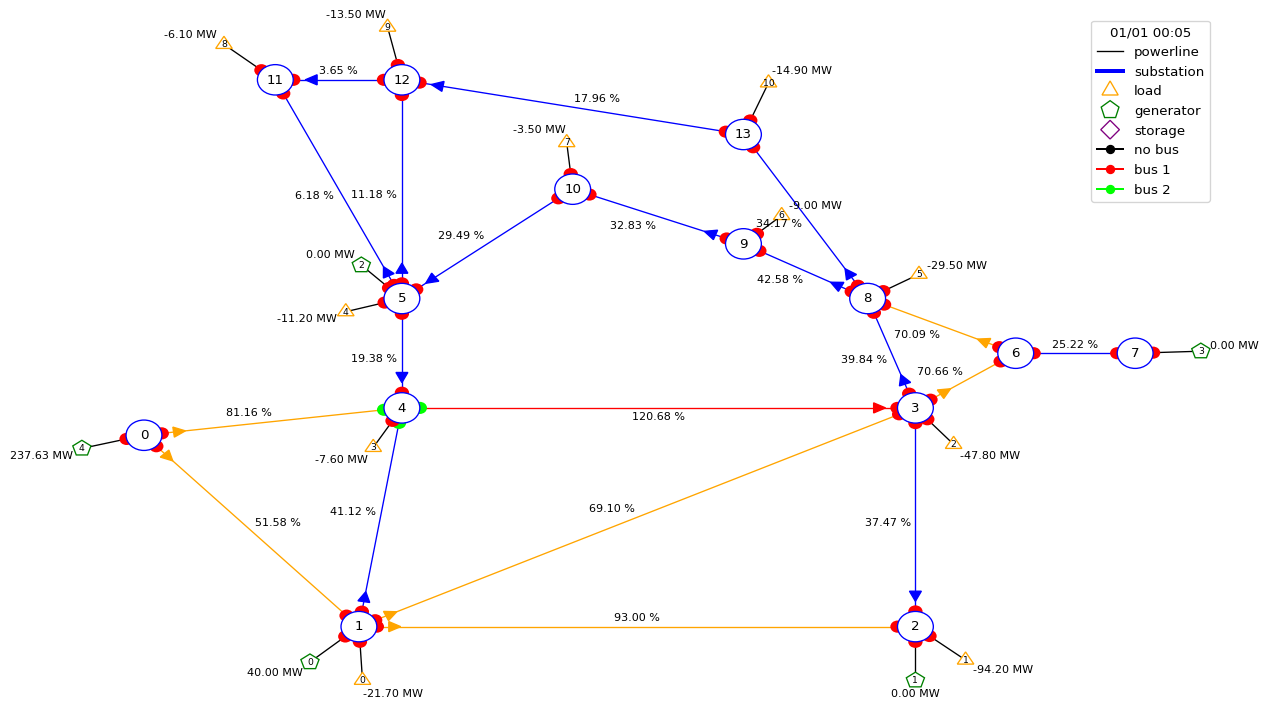

In [22]:
id_act=0
act=actions[id_act]
print(act)

obs_sim,*_=obs.simulate(act,time_step=0)

# if you want to plot all the observation
fig = plot_helper.plot_obs(obs_sim)
fig.show()

Only partially solves the overload

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - NOT force any line status
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - Set the bus of the following element(s):
	 	 - Assign bus 1 to line (extremity) id 10 [on substation 12]
	 	 - Assign bus 2 to line (extremity) id 18 [on substation 12]
	 	 - Assign bus 2 to line (origin) id 19 [on substation 12]
	 	 - Assign bus 1 to load id 9 [on substation 12]


/tmp/ipykernel_1347779/2902734041.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


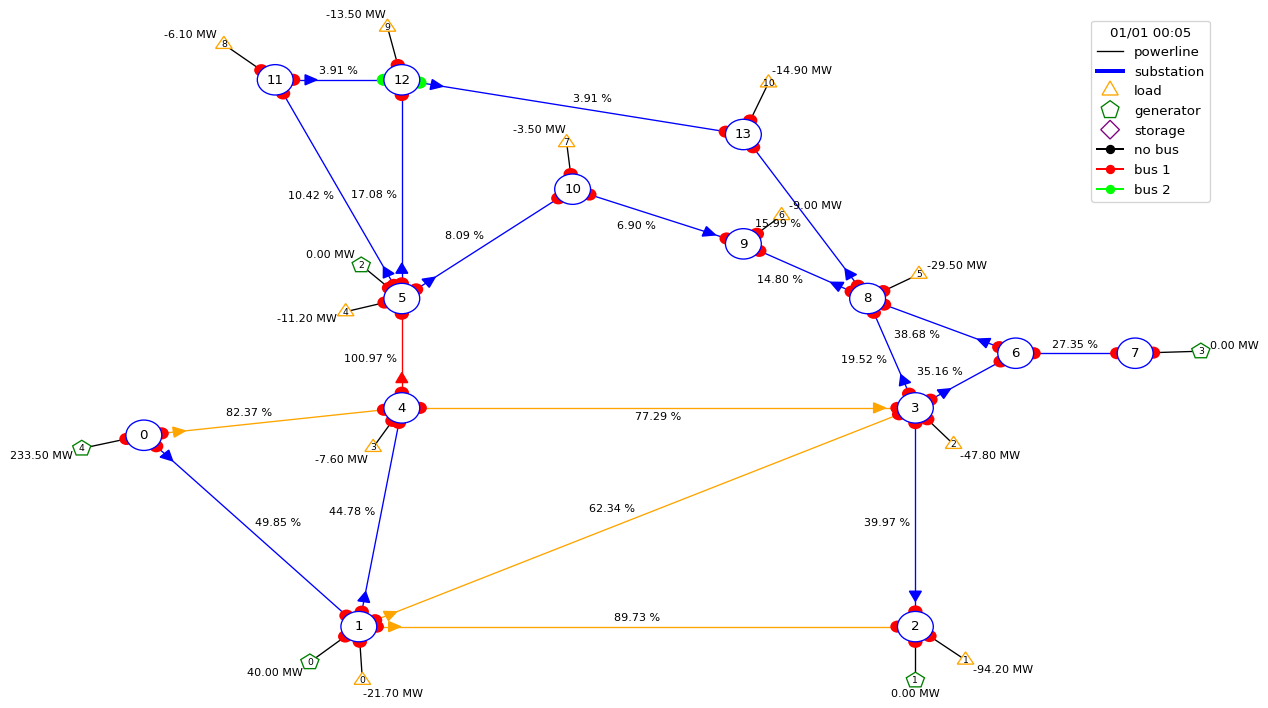

In [23]:
id_act=22
act=actions[id_act]
print(act)

obs_sim,*_=obs.simulate(act,time_step=0)

# if you want to plot all the observation
fig = plot_helper.plot_obs(obs_sim)
fig.show()

Save all results as plots to inspect in this folder

In [24]:
save_folder = os.path.join(sim.plot_folder, "Result graph")
print(save_folder)

output_plots/l2rpn_2019/linetocut_[9]/Scenario_0/Timestep_0/Result graph


In [ ]:

for elem in sim.save_bag:  # elem[0] = name, elem[1] = graph
    name = elem[0]
    simulated_obs = elem[1]
    save_file_path=os.path.join(save_folder,name)
    if hasattr(sim, 'plot'):
        sim.plot(simulated_obs, save_file_path)

we want to solve this

# Conclusion

In this notebook you have seen how to interpret the overload distribution graph and use some logic to leverage it for spotting the best substations and topologies for discovering topological remedial actions.

This graph can also directly be used by a human operator for spotting non explored actions, or for interpreting the results of the expert agents